<a href="https://colab.research.google.com/github/Mahdi-0599/NLP-HATESPEECH/blob/master/hatespeech_rnn_french.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/french-tweets/french_tweets.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline

In [ ]:
df = pd.read_csv('../input/french-tweets/french_tweets.csv',delimiter=',',encoding='latin-1')
df

,label,text
0,0,"- Awww, c'est un bummer. Tu devrais avoir davi..."
1,0,Est contrariÃ© qu'il ne puisse pas mettre Ã j...
2,0,J'ai plongÃ© plusieurs fois pour la balle. A r...
3,0,Tout mon corps a des dÃ©mangeaisons et comme s...
4,0,"Non, il ne se comporte pas du tout. je suis en..."
...,...,...
1526719,1,"Oui, cela fonctionne mieux que de l'attendre Ã..."
1526720,1,Je viens de me rÃ©veiller. Ne pas avoir d'Ã©co...
1526721,1,Thewdb.com - trÃ¨s cool d'entendre les vieille...
1526722,1,Ãtes-vous prÃªt pour votre mojo makeover? Dem...


In [ ]:
df.columns=['label','tweet']
df

,label,tweet
0,0,"- Awww, c'est un bummer. Tu devrais avoir davi..."
1,0,Est contrariÃ© qu'il ne puisse pas mettre Ã j...
2,0,J'ai plongÃ© plusieurs fois pour la balle. A r...
3,0,Tout mon corps a des dÃ©mangeaisons et comme s...
4,0,"Non, il ne se comporte pas du tout. je suis en..."
...,...,...
1526719,1,"Oui, cela fonctionne mieux que de l'attendre Ã..."
1526720,1,Je viens de me rÃ©veiller. Ne pas avoir d'Ã©co...
1526721,1,Thewdb.com - trÃ¨s cool d'entendre les vieille...
1526722,1,Ãtes-vous prÃªt pour votre mojo makeover? Dem...


Text(0.5, 1.0, 'Number of ham and spam messages')

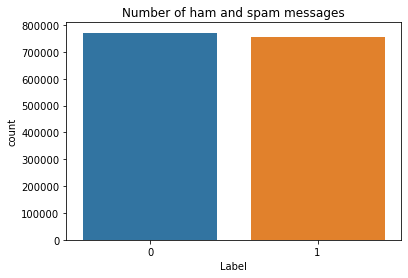

In [ ]:
sns.countplot(df.label)
plt.xlabel('Label')
plt.title('Number of ham and spam messages')

In [ ]:
def eval_fun(labels, preds):
    labels = label.split(' ')
    preds = tweet.split(' ')
    rr = (np.intersect1d(label, tweet))
    precision = np.float(len(rr)) / len(tweet)
    recall = np.float(len(rr)) / len(label)
    try:
        f1 = 2 * precision * recall / (precision + recall)
    except ZeroDivisionError:
        return (precision, recall, 0.0)
    return (precision, recall, f1)
print(1)

1


In [ ]:
import numpy as np
print("Hatred labeled: {}\nNon-hatred labeled: {}".format(
    (df.label == 1).sum(),
    (df.label == 0).sum()
))

Hatred labeled: 755120
Non-hatred labeled: 771604


In [ ]:
hashtags = df['tweet'].str.extractall('#(?P<hashtag>[a-zA-Z0-9_]+)').reset_index().groupby('level_0').agg(lambda x: ' '.join(x.values))
df.loc[:, 'hashtags'] = hashtags['hashtag']
df['hashtags'].fillna('', inplace=True)

df.loc[:, 'mentions'] = df['tweet'].str.count('@[a-zA-Z0-9_]+')

df.tweet = df.tweet.str.replace('@[a-zA-Z0-9_]+', '')

In [ ]:
df.tweet = df.tweet.str.replace('[^a-zA-Z]', ' ')

In [ ]:
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag, FreqDist, word_tokenize

stemmer = SnowballStemmer('english')
lemmer = WordNetLemmatizer()

part = {
    'N' : 'n',
    'V' : 'v',
    'J' : 'a',
    'S' : 's',
    'R' : 'r'
}

def convert_tag(penn_tag):
    if penn_tag in part.keys():
        return part[penn_tag]
    else:
        return 'n'


def tag_and_lem(element):
    sent = pos_tag(word_tokenize(element))
    return ' '.join([lemmer.lemmatize(sent[k][0], convert_tag(sent[k][1][0]))
                    for k in range(len(sent))])
    

df.loc[:, 'tweet'] = df['tweet'].apply(lambda x: tag_and_lem(x))
df.loc[:, 'hashtags'] = df['hashtags'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

In [ ]:
X = df.tweet
Y = df.label
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

In [ ]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.30)

In [ ]:
from keras.preprocessing.text import Tokenizer
max_words = 1000
max_len = 100
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [ ]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(64,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [ ]:

model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 50)           50000     
_________________________________________________________________
lstm (LSTM)                  (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 64)                4160      
_________________________________________________________________
activation (Activation)      (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                

In [ ]:
history = model.fit(sequences_matrix,Y_train,batch_size=64,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Epoch 1/10
13359/13359 [==============================] - 931s 70ms/step - loss: 0.4994 - accuracy: 0.7573 - val_loss: 0.4793 - val_accuracy: 0.7686
Epoch 2/10
13359/13359 [==============================] - 933s 70ms/step - loss: 0.4803 - accuracy: 0.7699 - val_loss: 0.4714 - val_accuracy: 0.7726
Epoch 3/10
13359/13359 [==============================] - 937s 70ms/step - loss: 0.4747 - accuracy: 0.7740 - val_loss: 0.4699 - val_accuracy: 0.7753
Epoch 4/10
13359/13359 [==============================] - 938s 70ms/step - loss: 0.4711 - accuracy: 0.7767 - val_loss: 0.4680 - val_accuracy: 0.7751
Epoch 5/10
13359/13359 [==============================] - 937s 70ms/step - loss: 0.4691 - accuracy: 0.7784 - val_loss: 0.4660 - val_accuracy: 0.7768
Epoch 6/10
13359/13359 [==============================] - 935s 70ms/step - loss: 0.4687 - accuracy: 0.7795 - val_loss: 0.4668 - val_accuracy: 0.7771


In [ ]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [ ]:
accr = model.evaluate(test_sequences_matrix,Y_test)

14314/14314 [==============================] - 205s 14ms/step - loss: 0.4684 - accuracy: 0.7772


In [ ]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.468
  Accuracy: 0.777


In [ ]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

KeyError: 'acc'